# A linear classifier in pure TensorFlow

First, let’s come up with some nicely linearly separable synthetic data to work with: two classes of points in a 2D plane. We’ll generate each class of points by drawing their coordinates from a random distribution with a specific covariance matrix and a specific mean.

We’ll reuse the same covariance matrix for both point clouds, but we’ll use two different mean values—the point clouds will have the same shape, but different positions.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

**Generating two classes of random points in a 2D plane**

In [2]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [3]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

**Generating the corresponding targets (0 and 1)**

Let’s generate the corresponding target labels, an array of zeros and ones of shape (2000, 1), where targets[i, 0] is 0 if inputs[i] belongs to class 0 (and inversely).

In [4]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

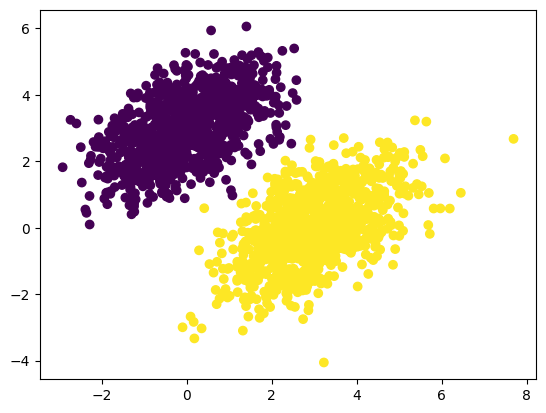

In [5]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

Now let’s create a linear classifier that can learn to separate these two blobs. A linear classifier is an affine transformation (prediction = W • input + b) trained to minimize the square of the difference between predictions and the targets.

Let’s create our variables, W and b, initialized with random values and with zeros, respectively.

In [6]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

I0000 00:00:1749663897.577067   18793 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


**The forward pass function**

Because our linear classifier operates on 2D inputs, W is really just two scalar coefficients, w1 and w2: W = [[w1], [w2]]. Meanwhile, b is a single scalar coefficient. As such, for a given input point [x, y], its prediction value is prediction = [[w1], [w2]] • [x, y] + b = w1 * x + w2 * y + b.

In [7]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**The mean squared error loss function**

In [8]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

> per_sample_losses will be a tensor with the same shape as targets and predictions, containing per-sample loss scores.
> We need to average these per-sample loss scores into a single scalar loss value: this is what reduce_mean does.

**The training step function**

Next is the training step, which receives some training data and updates the weights W and b so as to minimize the loss on the data.

In [9]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**The batch training loop**

In [10]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 2.3609
Loss at step 1: 0.1573
Loss at step 2: 0.1048
Loss at step 3: 0.0919
Loss at step 4: 0.0850
Loss at step 5: 0.0794
Loss at step 6: 0.0744
Loss at step 7: 0.0699
Loss at step 8: 0.0658
Loss at step 9: 0.0621
Loss at step 10: 0.0588
Loss at step 11: 0.0557
Loss at step 12: 0.0529
Loss at step 13: 0.0504
Loss at step 14: 0.0481
Loss at step 15: 0.0460
Loss at step 16: 0.0441
Loss at step 17: 0.0424
Loss at step 18: 0.0408
Loss at step 19: 0.0394
Loss at step 20: 0.0381
Loss at step 21: 0.0369
Loss at step 22: 0.0359
Loss at step 23: 0.0349
Loss at step 24: 0.0340
Loss at step 25: 0.0332
Loss at step 26: 0.0325
Loss at step 27: 0.0318
Loss at step 28: 0.0312
Loss at step 29: 0.0307
Loss at step 30: 0.0302
Loss at step 31: 0.0297
Loss at step 32: 0.0293
Loss at step 33: 0.0290
Loss at step 34: 0.0286
Loss at step 35: 0.0283
Loss at step 36: 0.0280
Loss at step 37: 0.0278
Loss at step 38: 0.0276
Loss at step 39: 0.0274


After 40 steps, the training loss seems to have stabilized around 0.027. Let’s plot how our linear model classifies the training data points. Because our targets are zeros and ones, a given input point will be classified as “0” if its prediction value is below 0.5, and as “1” if it is above 0.5

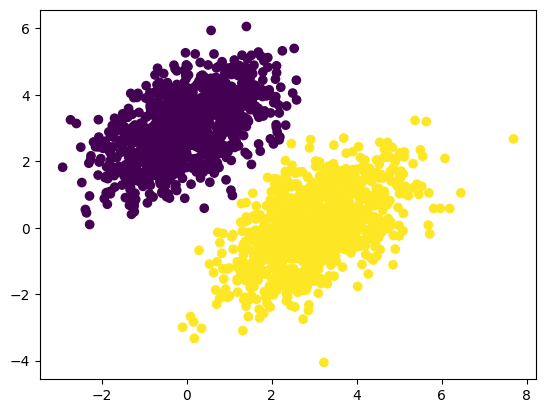

In [11]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

Recall that the prediction value for a given point [x, y] is simply prediction == [[w1], [w2]] • [x, y] + b == w1 * x + w2 * y + b. Thus, class 0 is defined as w1 * x + w2 * y + b < 0.5, and class 1 is defined as w1 * x + w2 * y + b > 0.5. You’ll notice that what you’re looking at is really the equation of a line in the 2D plane: w1 * x + w2 * y + b = 0.5. Above the line is class 1, and below the line is class 0. You may be used to seeing line equations in the format y = a * x + b; in the same format, our line becomes y = - w1 / w2 * x + (0.5 - b) / w2.

Let’s plot this line:

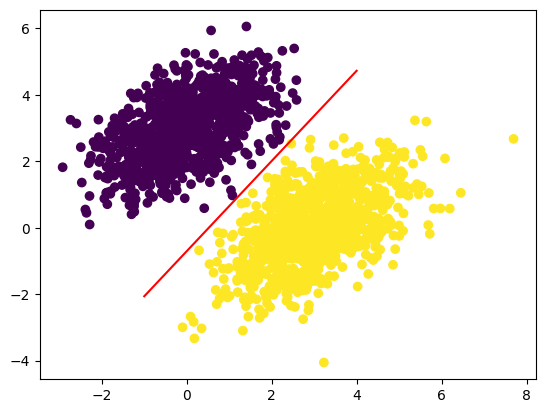

In [12]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)